In [0]:
#Reading in libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#Setting working directory in colab
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/'My Drive'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [0]:
class Network:
    def __init__(self,nodes,edges):

        #Make sure 'nodes' argument is a string
        if type(nodes) != str:
          raise ValueError("Nodes must be a string stipulating the location of the nodes file")

        #Make sure 'edges' argument is a string
        if type(edges) != str:
          raise ValueError("Edges must be a string stipulating the location of the edges file")

        #Reading in data
        self.nodes = pd.read_csv(nodes)
        self.edges = pd.read_csv(edges)

        #Setting the nodes to int
        self.nodes.x = self.nodes.x.astype(int)
        self.nodes.y = self.nodes.y.astype(int)

        #Making sure columns are named correctly
        self.nodes.columns = ['x','y']
        self.edges.columns = ['from','to']

        #Taking unique values from edges
        self.unique_entries = list(self.edges["from"].unique())

        #Setting all unique entries as unoccupied
        self.unoccupied = self.unique_entries.copy()
        self.occupied = list()

        #Creating empty lists to populate with run
        self.flow = {}
        self.occupancy = {}

        #Setting ran variable as 0 to check run has been executed prior to plots
        self.ran = 0

    #Birth method changes entries from unoccupied to occupied    
    def birth(self):
        for i in self.unoccupied:
          if random.random()<self.pbirth:
            self.unoccupied.remove(i)
            self.occupied.append(i)

    #Death method changes entries from occupied to unoccupied
    def death(self):
        for i in self.occupied:
          if random.random()<self.pdeath:
            self.occupied.remove(i)
            self.unoccupied.append(i)

            #Incrementing flow when entries change from occupied to unoccupied
            self.flow[(self.m,i)] += 1

    #Flowing method moves cars where joining roads are unoccupied
    def flowing(self):
      
      #Creating a copy of occupied as 'junction'
      self.junction = self.occupied.copy()

      #Randomly go through 'junction' entries and move if unoccupied road available
      for i in random.sample(self.junction,len(self.junction)):
        
        #Check if road is available
        self.candidates = self.edges['to'].loc[(self.edges['from'] == i) & ~(self.edges['to'].isin(self.occupied))].values.tolist()

        #Check amount of available roads available
        self.k = len(self.candidates) - 1
        
        #If no roads are available then do nothing
        if self.k == -1:
          pass
        
        #If roads are available then move the car to a randomly selected road
        else:
          self.random_choice = random.randint(0, self.k)
          self.selection = self.candidates[self.random_choice]
        
          self.occupied.remove(i)
          self.unoccupied.append(i)

          #Increment flow when entries change from occupied to unoccupied
          self.flow[(self.m,i)] += 1

          self.unoccupied.remove(self.selection)
          self.occupied.append(self.selection)

    def run(self,minutes,pbirth=0.001,pdeath=0.001):
        #Raise error if minutes not an integer
        if type(minutes) != int:
          raise ValueError("Minutes must be an integer")

        self.pbirth = pbirth
        self.pdeath = pdeath
        self.minutes = minutes

        #Create an empty dataframe to store segment and occupied status
        self.status_df = pd.DataFrame(data=None,columns=['segment','occupied'])

        #Cycle through every segment and minute and set flow and occupancy as 0
        for self.m in range(minutes):
          for u in self.unique_entries:
            self.flow[(self.m,u)] = 0
            self.occupancy[(self.m,u)] = 0
          
          #For every second in a minute, run the birth, death and flowing methods
          for s in range(60):
            self.birth()
            self.death()
            self.flowing()

            #At the end of every second, increment values if a space is occupied
            for o in self.occupied:
              self.occupancy[(self.m,o)] += 1
        
        #Append occupied entries to the 'status_df' dataframe, recording occupied as 1
        self.status_df = self.status_df.append(pd.DataFrame(zip(self.occupied,
                                                                [1] * len(self.occupied)),
                                                            columns=['segment','occupied']))

        #Append unoccupied entries to the 'status_df' dataframe, recording occupied as 0 
        self.status_df = self.status_df.append(pd.DataFrame(zip(self.unoccupied,
                                                                [0] * len(self.unoccupied)),
                                                            columns=['segment','occupied']))
        
        #Store the flow dictionary as a dataframe, separating out minute and segment
        self.flow_df = pd.Series(self.flow).reset_index()
        self.flow_df.columns = ['minute', 'segment', 'flow']

        #Store the occupancy dictionary as a dataframe, separating out minute and segment
        self.occupancy_df = pd.Series(self.occupancy).reset_index()
        self.occupancy_df.columns = ['minute', 'segment', 'occupancy']

        #Merge both flow and occupancy in to the same dataframe
        self.minute_summary_df = self.flow_df.merge(self.occupancy_df)

        #Add on occupancy as a % of each minute by dividing by 60, stored as a separate field
        self.minute_summary_df["occupancy_pct"] = self.minute_summary_df.occupancy / 60

        #Update 'ran' attribute to 1
        self.ran = 1

    def plot_network(self):
        #Return error if run method has not been executed
        if self.ran == 0:
          raise NotImplementedError("Run method must have been executed before plotting")

        #Create a copy of the nodes dataframe and store the index as 'segment'
        self.nodes_plot = self.nodes.copy()
        self.nodes_plot['segment'] = self.nodes_plot.index

        #Merge wit the status_df dataframe created as part of the run method
        self.status_nodes = self.status_df.merge(self.nodes_plot)

        #Plot the network
        self.colours = ["green", "red"]
        sns.relplot("x", "y", hue="occupied",
                    data=self.status_nodes,
                    palette=sns.color_palette(self.colours),
                    legend=None,
                    height=10)
        plt.axis('off')
        plt.title(None)

        #Creating a dataset combining edges with node coordinates for 'from' and 'to'
        self.edges_nodes_merged = self.edges.merge(self.nodes_plot,left_on='from',right_on='segment')
        self.to_nodes = self.nodes_plot.copy()
        self.to_nodes.columns = ['to_x','to_y','segment']
        self.combined_locations = self.edges_nodes_merged.merge(self.to_nodes, left_on='to',right_on='segment')

        #Calculating coordinate changes between 'from' and 'to'
        self.combined_locations['dx'] = self.combined_locations.to_x - self.combined_locations.x
        self.combined_locations['dy'] = self.combined_locations.to_y - self.combined_locations.y

        #Append arrows to the plot
        for i in range(len(self.combined_locations)):
          self.arrow_df = self.combined_locations.iloc[i]
          plt.arrow(x=self.arrow_df.x,
                    y=self.arrow_df.y,
                    dx=self.arrow_df.dx/1.5,
                    dy=self.arrow_df.dy/1.5,
                    length_includes_head=True,
                    head_width=0.25)

    def plot_occupancy(self,segment):
        #Return error if run method has not been executed
        if self.ran == 0:
          raise NotImplementedError("Run method must have been executed before plotting")

        #Raise error if segments not a list
        if type(segment) != list:
          raise ValueError("Segment must contain a list")

        #Raise error if segment values are out of bounds
        for i in segment:
          if i not in self.unique_entries:
            raise ValueError("Segment value is out of bounds")

        #Limit selection to only those included in the 'segment' argument and spread the data in to a wide format
        self.segments = segment
        self.occupancy_selection = self.minute_summary_df.loc[self.minute_summary_df["segment"].isin(self.segments)].copy()
        self.occupancy_wide = self.occupancy_selection.pivot(index='minute', columns='segment', values='occupancy_pct')

        #Plot occupancy over time
        self.occupancy_plot = self.occupancy_wide.plot()
        self.occupancy_plot.set_ylabel("occupancy")
        self.occupancy_plot.set_title("Occupancy")

    def plot_flow(self,segment):
        #Return error if run method has not been executed
        if self.ran == 0:
          raise NotImplementedError("Run method must have been executed before plotting")

        #Raise error if segments not a list
        if type(segment) != list:
          raise ValueError("Segment must contain a list")

        #Raise error if segment values are out of bounds
        for i in segment:
          if i not in self.unique_entries:
            raise ValueError("Segment value is out of bounds")
        
        #Limit selection to only those included in the 'segment' argument and spread the data in to a wide format
        self.segments = segment
        self.flow_selection = self.minute_summary_df.loc[self.minute_summary_df["segment"].isin(self.segments)].copy()
        self.flow_wide = self.flow_selection.pivot(index='minute', columns='segment', values='flow')

        #Plot flow over time
        self.flow_plot = self.flow_wide.plot()
        self.flow_plot.set_ylabel("flow")
        self.flow_plot.set_title("Flow")

    def plot_fundamental_diagram(self,minute):
        #Return error if run method has not been executed
        if self.ran == 0:
          raise NotImplementedError("Run method must have been executed before plotting")

        #Raise error if minute not an integer
        if type(minute) != int:
          raise ValueError("Minute must be an integer")

        #Raise error if minute values are out of bounds
        if minute not in range(self.minutes):
          raise ValueError("Minute value is out of bounds")  

        #Limit selection to the minute stipulated in the minutes argument
        self.minute = minute
        self.fd_selection = self.minute_summary_df.loc[self.minute_summary_df["minute"] == self.minute].copy()

        #Plot the Fundamental Diagram
        self.fd_plot = sns.relplot(x="occupancy_pct",y="flow",data=self.fd_selection)
        self.fd_plot.fig.suptitle("Fundamental Diagram")
        plt.xlabel("occupancy")

In [0]:
n = Network("nodes.csv", "edges.csv")

In [0]:
n.run(minutes=30) #Takes around 5 mins to run on Google Colab where minutes = 30

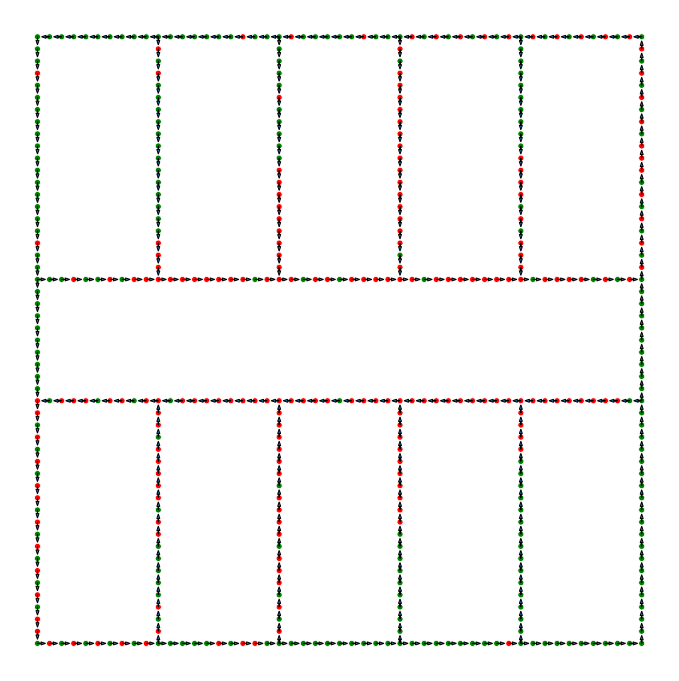

In [6]:
n.plot_network()

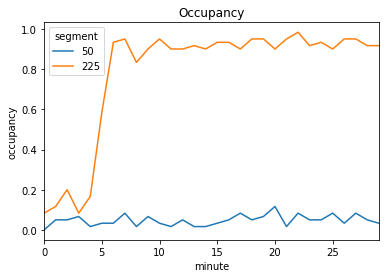

In [7]:
n.plot_occupancy(segment=[50,225])

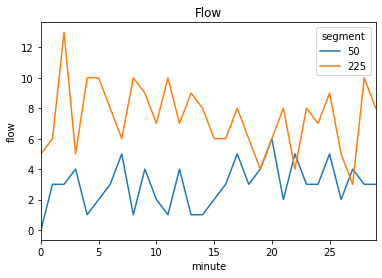

In [8]:
n.plot_flow(segment=[50,225])

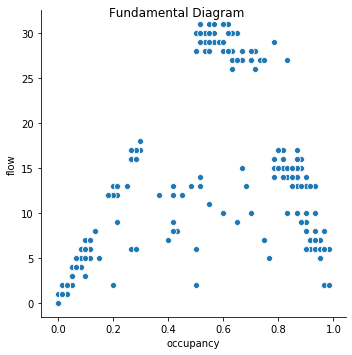

In [9]:
n.plot_fundamental_diagram(minute=10)